# Loading the Dataset

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from utils import literal_evaluate, horizontal
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors as pc
import re
plt.style.use("ggplot")

metacritic = pd.read_csv("data/metacritic.csv")

# Feature Engineering

In [23]:
def perform_feature_engineering(metacritic: pd.DataFrame) -> pd.DataFrame:
    # Standardizing the metacritic platforms info data
    metacritic['platforms_info'] = metacritic['platforms_info'].apply(literal_evaluate)

    def extract_metascore_count(text):
        match = re.search(r'\d+', text)
        if match:
            return int(match.group())
        return None

    metacritic_exploded_platforms = metacritic.explode('platforms_info')
    metacritic_exploded_platforms.rename(mapper={'platforms_info': 'platform_info'}, axis=1, inplace=True)
    new_feature_columns = []
    for index, row in metacritic_exploded_platforms.iterrows():
        platform_info = row['platform_info']
        if type(platform_info) is not dict:
            new_feature_columns.append({
                'platform_name': np.nan,
                'platform_metascore': np.nan,
                'platform_metascore_count': np.nan
            })
            continue
        platform_name = platform_info.get('Platform')
        platform_metascore = platform_info.get('Platform Metascore')
        platform_metascore_count_text = platform_info.get('Platform Metascore Count')
        platform_metascore_count = extract_metascore_count(platform_metascore_count_text)
        new_feature_columns.append({
            'platform_name': platform_name,
            'platform_metascore': platform_metascore,
            'platform_metascore_count': platform_metascore_count
        })
    new_feature_columns = pd.DataFrame(new_feature_columns)
    new_feature_columns['platform_metascore'] = pd.to_numeric(new_feature_columns['platform_metascore'], errors='coerce').astype("Int64")
    new_feature_columns['platform_metascore_count'] = pd.to_numeric(new_feature_columns['platform_metascore_count'], errors='coerce').astype("Int64")
    metacritic_exploded_platforms.reset_index(drop=True, inplace=True)

    metacritic = pd.concat([metacritic_exploded_platforms, new_feature_columns], axis=1)

    metacritic['release_date'] = pd.to_datetime(metacritic['release_date'], format='%Y-%m-%d')
    return metacritic
metacritic = perform_feature_engineering(metacritic)

# Basic Statistics

In [28]:
metacritic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29661 entries, 0 to 29660
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   name                      29661 non-null  object        
 1   release_date              29598 non-null  datetime64[ns]
 2   developer                 29494 non-null  object        
 3   publisher                 29494 non-null  object        
 4   genres                    29661 non-null  object        
 5   product_rating            24044 non-null  object        
 6   user_score                25860 non-null  float64       
 7   user_ratings_count        25117 non-null  float64       
 8   platform_info             29653 non-null  object        
 9   platform_name             29653 non-null  object        
 10  platform_metascore        25160 non-null  Int64         
 11  platform_metascore_count  29653 non-null  Int64         
dtypes: Int64(2), datet

In [31]:
horizontal([metacritic.describe(), metacritic[metacritic.select_dtypes(include='object').columns].drop('platform_info', axis=1).describe()])
metacritic.head()

,name,release_date,developer,publisher,genres,product_rating,user_score,user_ratings_count,platform_info,platform_name,platform_metascore,platform_metascore_count
0,Ziggurat (2012),2012-02-17,Action Button Entertainment,Freshuu Inc.,Action,NaN,69.0,14.0,"{'Platform': 'iOS (iPhone/iPad)', 'Platform Me...",iOS (iPhone/iPad),83,18
1,4X4 EVO 2,2001-11-15,Terminal Reality,Gathering,Auto Racing Sim,Rated E For Everyone,NaN,NaN,"{'Platform': 'Xbox', 'Platform Metascore': '59...",Xbox,59,15
2,4X4 EVO 2,2001-11-15,Terminal Reality,Gathering,Auto Racing Sim,Rated E For Everyone,NaN,NaN,"{'Platform': 'PC', 'Platform Metascore': '69',...",PC,69,9
3,4X4 EVO 2,2001-11-15,Terminal Reality,Gathering,Auto Racing Sim,Rated E For Everyone,NaN,NaN,"{'Platform': 'GameCube', 'Platform Metascore':...",GameCube,56,7
4,MotoGP 2 (2001),2002-01-22,Namco,Namco,Auto Racing Sim,Rated E For Everyone,58.0,NaN,"{'Platform': 'PlayStation 2', 'Platform Metasc...",PlayStation 2,78,18


In [52]:
# def plot_correlation_heatmap() -> plt.Figure:
#     plt.figure()
#     sns.heatmap(
#         metacritic.select_dtypes(include='number').corr(),
#         annot=True,
#         cmap='coolwarm',
#         vmax=1,
#         vmin=-1,
#         square=True
#     )
#     return plt.gcf()
# fig = plot_correlation_heatmap()

def plot_correlation_heatmap() -> go.Figure:
    corr_matrix = metacritic.select_dtypes(include='number').corr()
    corr_matrix = np.round(corr_matrix, 2)

    fig = px.imshow(
        corr_matrix,
        text_auto=True, 
        color_continuous_scale='RdBu_r',
        zmin=-1,
        zmax=1,
        aspect="auto"
    )
    
    fig.update_layout(
        title='Correlation heatmap',
        width=700,
        height=700,
        margin=dict(l=150, r=120, t=100, b=150)
    )
    
    return fig

fig = plot_correlation_heatmap()
fig.show()

# Platforms Info

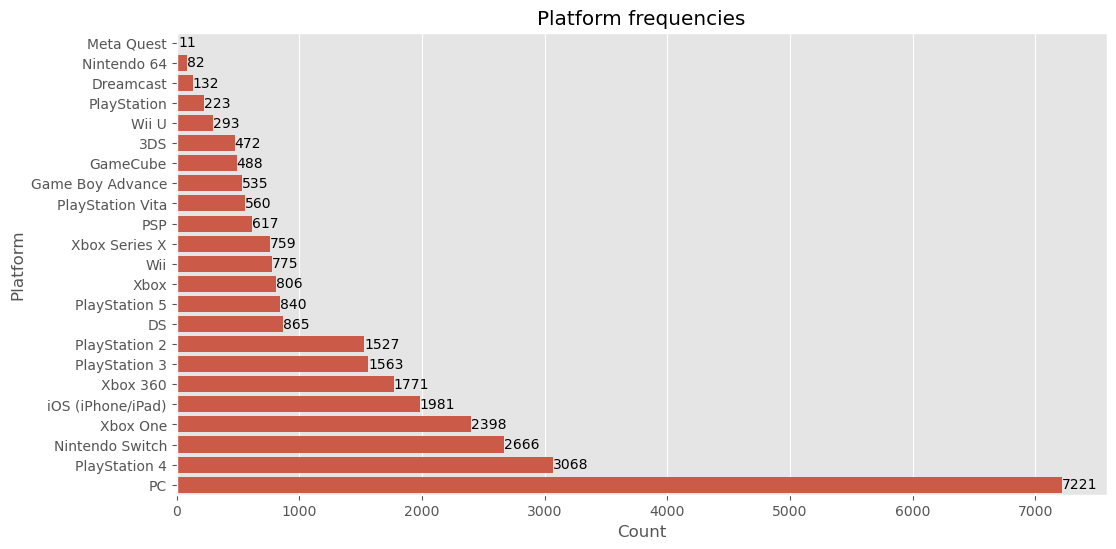

In [40]:
def plot_platform_frequencies() -> plt.Figure:  
    platform_frequencies = metacritic.groupby('platform_name').size()
    platform_frequencies.name = 'count'
    platform_frequencies = pd.DataFrame({
        'platform_name': platform_frequencies.index,
        'count': platform_frequencies.values
    })
    platform_frequencies.sort_values(by='count', ascending=True, inplace=True)

    fig = plt.figure(figsize=(12,6))
    ax = sns.barplot(
        data=platform_frequencies,
        x='count',
        y='platform_name',
        orient='h',
    )
    ax.bar_label(ax.containers[0])
    plt.title('Platform frequencies')
    plt.xlabel('Count')
    plt.ylabel('Platform')
    return fig
fig = plot_platform_frequencies()

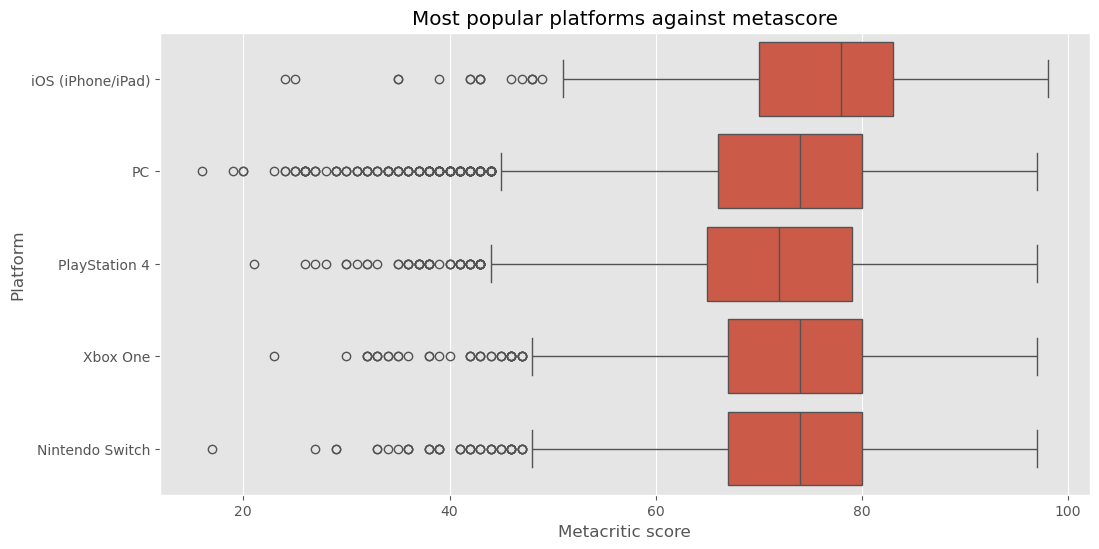

In [42]:
# Get average review scores per platform
# Does the platform influence our average critic review score?

def plot_most_popular_platforms_boxplots() -> plt.Figure:
    most_popular_platforms = ['PC', 'PlayStation 4', 'Nintendo Switch', 'Xbox One', 'iOS (iPhone/iPad)']
    most_popular_platforms = metacritic.loc[metacritic['platform_name'].isin(most_popular_platforms)]

    fig = plt.figure(figsize=(12, 6))
    sns.boxplot(
        data = most_popular_platforms,
        x = 'platform_metascore',
        y = 'platform_name',
        orient='h'
    )
    plt.title("Most popular platforms against critics review score")
    plt.xlabel("Metacritic score")
    plt.ylabel("Platform")
    return fig
fig = plot_most_popular_platforms_boxplots()

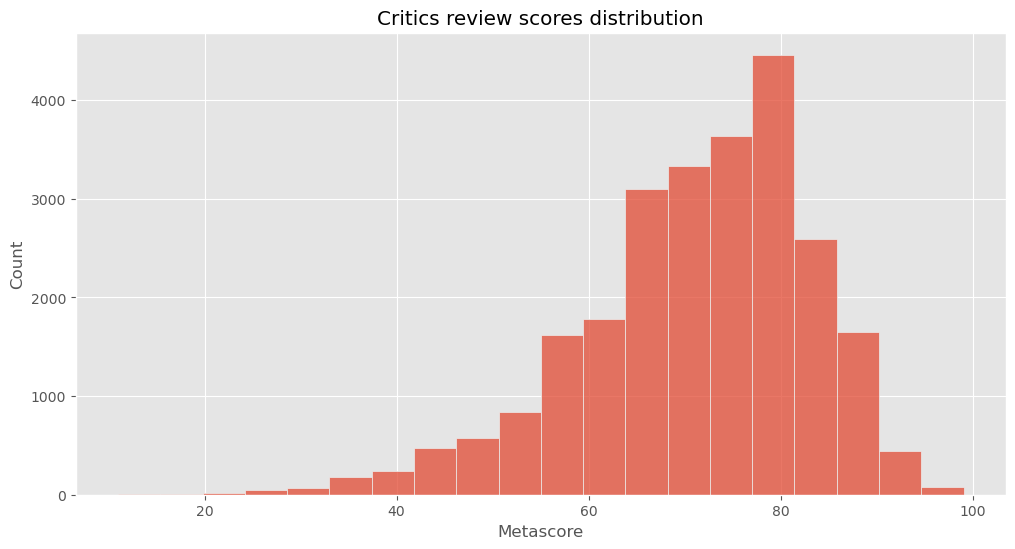

In [68]:
# Top most reviewed games by top 3 platforms
# most reviewed by critics

pc_games = metacritic[metacritic['platform_name'] == 'PC']
ascending = False
n = 10
most_popular_pc_games_by_critics = pc_games.sort_values(by='platform_metascore_count', ascending = ascending)
most_popular_pc_games_by_users = pc_games.sort_values(by='user_ratings_count', ascending = ascending)

def plot_critic_review_count_distribution() -> plt.Figure:
    fig = plt.figure(figsize=(12, 6))
    sns.histplot(
        data = metacritic,
        x = 'platform_metascore',
        bins = 20,
    )
    plt.title("Critics review scores distribution")
    plt.xlabel("Metascore")
    plt.ylabel("Count")

    return fig
fig = plot_critic_review_count_distribution()

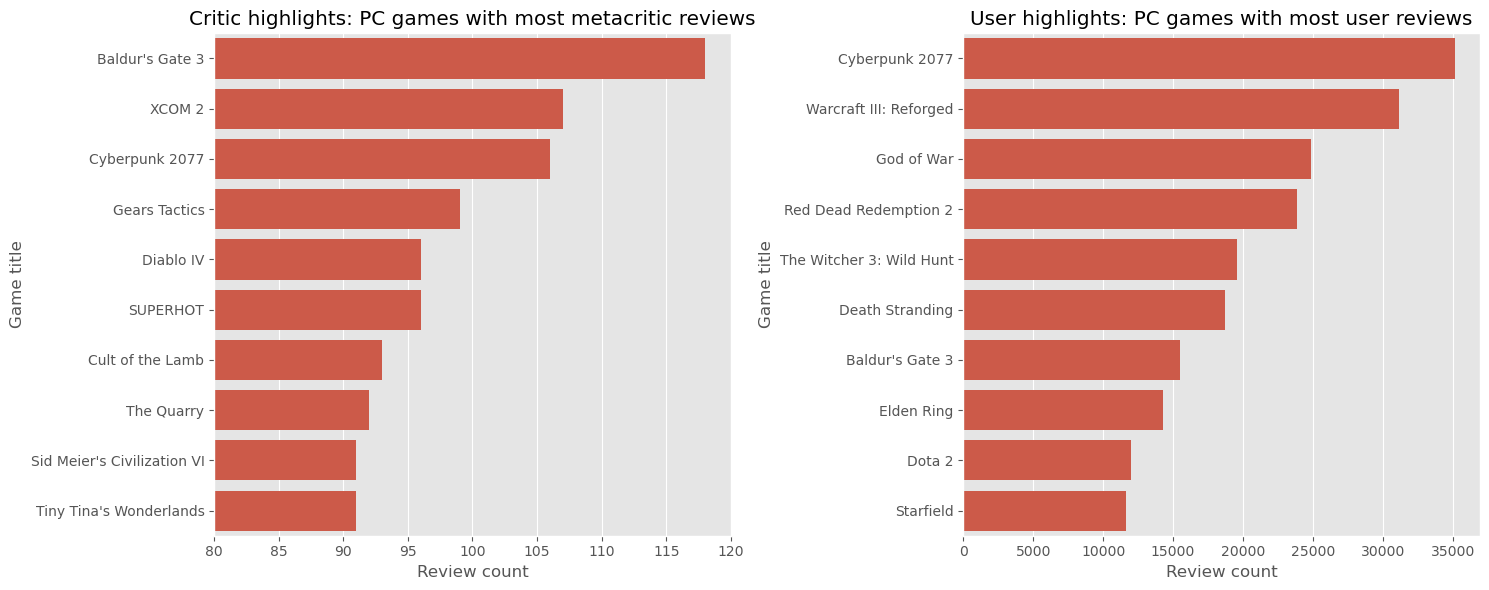

In [65]:

def plot_most_popular_pc_games_by_critics_and_users(n = 10) -> plt.Figure:
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes: list[plt.Axes] = axes.ravel()
    sns.barplot(
        data = most_popular_pc_games_by_critics.head(n),
        x = 'platform_metascore_count',
        y = 'name',
        ax = axes[0]
    )
    axes[0].set_xlim([80, 120])
    axes[0].set_title('Critic highlights: PC games with most metacritic reviews')
    axes[0].set_xlabel('Review count')
    axes[0].set_ylabel('Game title')
    
    sns.barplot(
        data = most_popular_pc_games_by_users.head(n),
        x = 'user_ratings_count',
        y = 'name',
        ax = axes[1]
    )
    axes[1].set_title('User highlights: PC games with most user reviews')
    axes[1].set_xlabel('Review count')
    axes[1].set_ylabel('Game title')

    plt.tight_layout()
    return fig
fig = plot_most_popular_pc_games_by_critics_and_users(10)



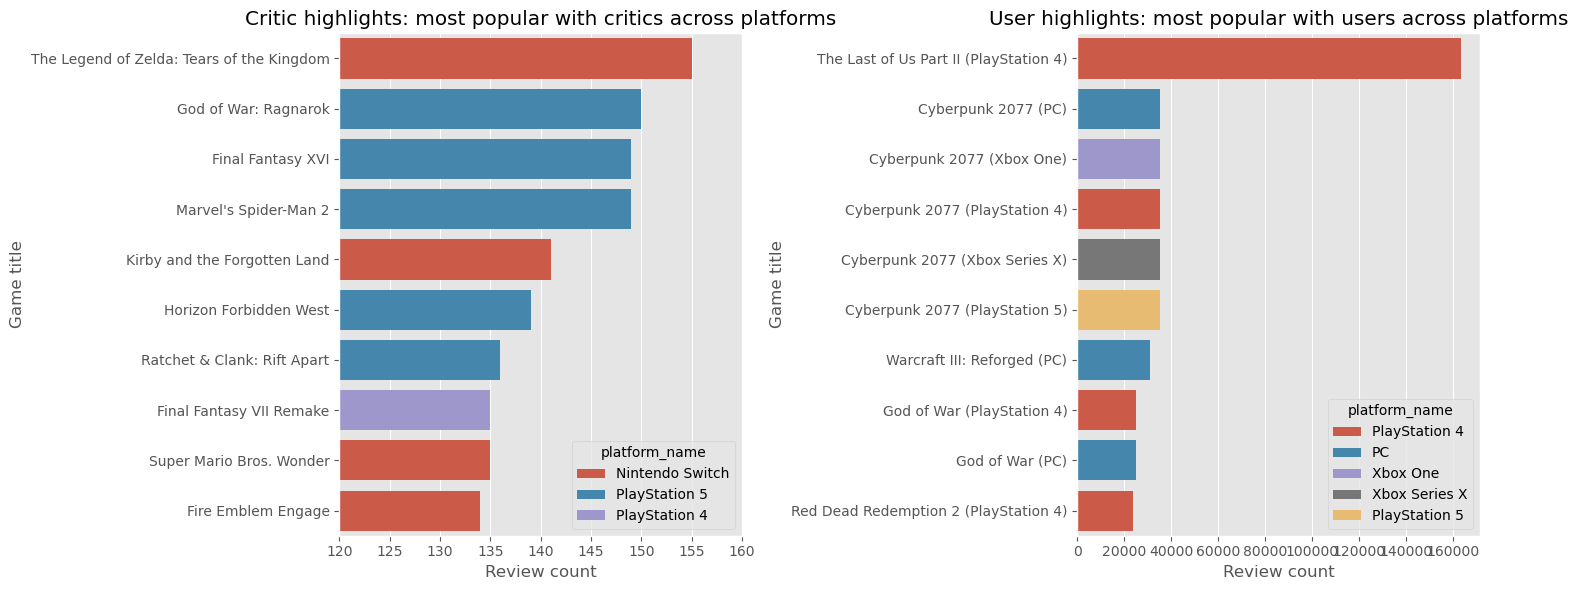

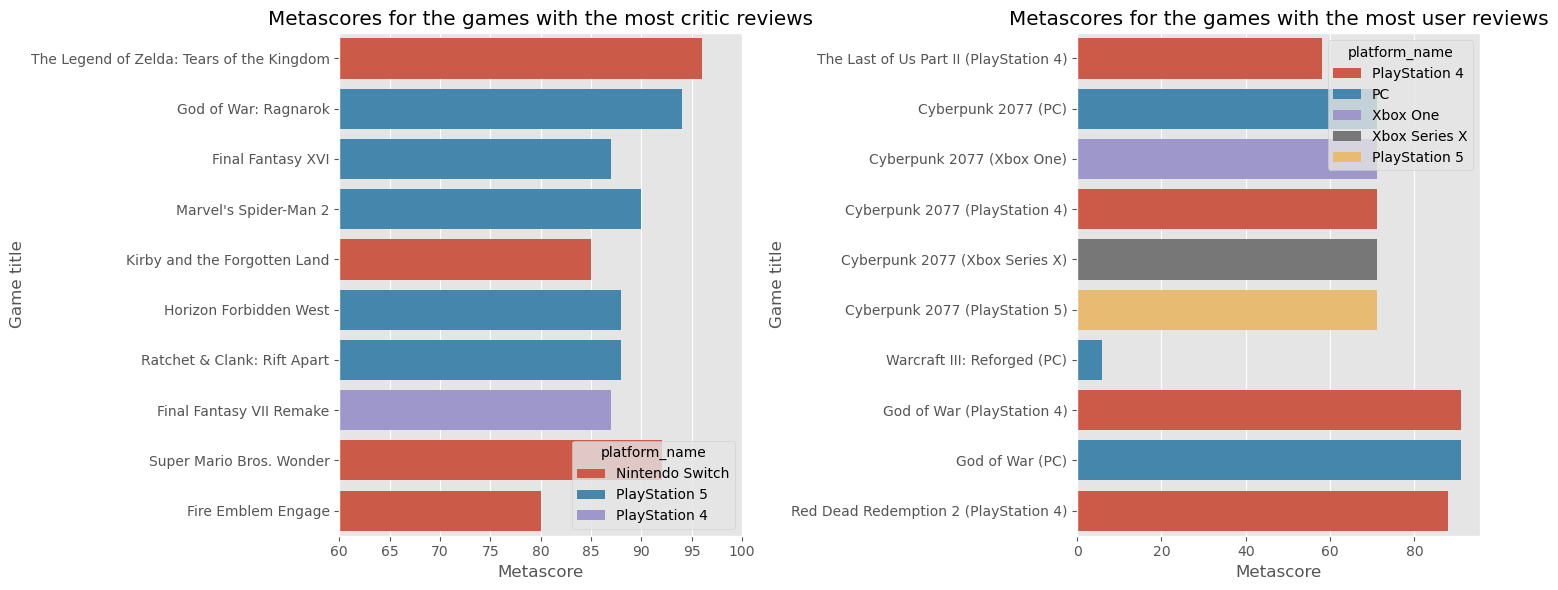

In [72]:
# What about for all platforms?
def plot_most_popular_platforms() -> plt.Figure:
    metacritic['name_and_platform'] = metacritic['name'] + ' (' + metacritic['platform_name'] + ')'
    most_popular_by_critics = metacritic.sort_values(by='platform_metascore_count', ascending = ascending)
    most_popular_by_users = metacritic.sort_values(by='user_ratings_count', ascending = ascending)

    fig_1, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes: list[plt.Axes] = axes.ravel()
    sns.barplot(
        data = most_popular_by_critics.head(n),
        x = 'platform_metascore_count',
        y = 'name',
        hue = 'platform_name',
        ax = axes[0]
    )
    axes[0].set_title('Critic highlights: most popular with critics across platforms')
    axes[0].set_xlabel('Review count')
    axes[0].set_ylabel('Game title')
    axes[0].set_xlim([120, 160])
    sns.barplot(
        data = most_popular_by_users.head(n),
        x = 'user_ratings_count',
        y = 'name_and_platform',
        hue = 'platform_name',
        ax = axes[1]
    )
    axes[1].set_title('User highlights: most popular with users across platforms')
    axes[1].set_xlabel('Review count')
    axes[1].set_ylabel('Game title')

    plt.tight_layout()

    fig_2, axes = plt.subplots(1, 2, figsize=(15, 6))
    sns.barplot(
        data = most_popular_by_critics.head(n),
        x = 'platform_metascore',
        y = 'name',
        hue = 'platform_name',
        ax = axes[0]
    )
    axes[0].set_title('Metascores for the games with the most critic reviews')
    axes[0].set_xlabel("Metascore")
    axes[0].set_ylabel('Game title')
    axes[0].set_xlim([60, 100])

    sns.barplot(
        data = most_popular_by_users.head(n),
        x = 'user_score',
        y = 'name_and_platform',
        hue = 'platform_name',
        ax = axes[1]
    )
    axes[1].set_title('Metascores for the games with the most user reviews')
    axes[1].set_xlabel("Metascore")
    axes[1].set_ylabel('Game title')

    plt.tight_layout()
    return fig_1, fig_2
fig_1, fig_2 = plot_most_popular_platforms()



1931


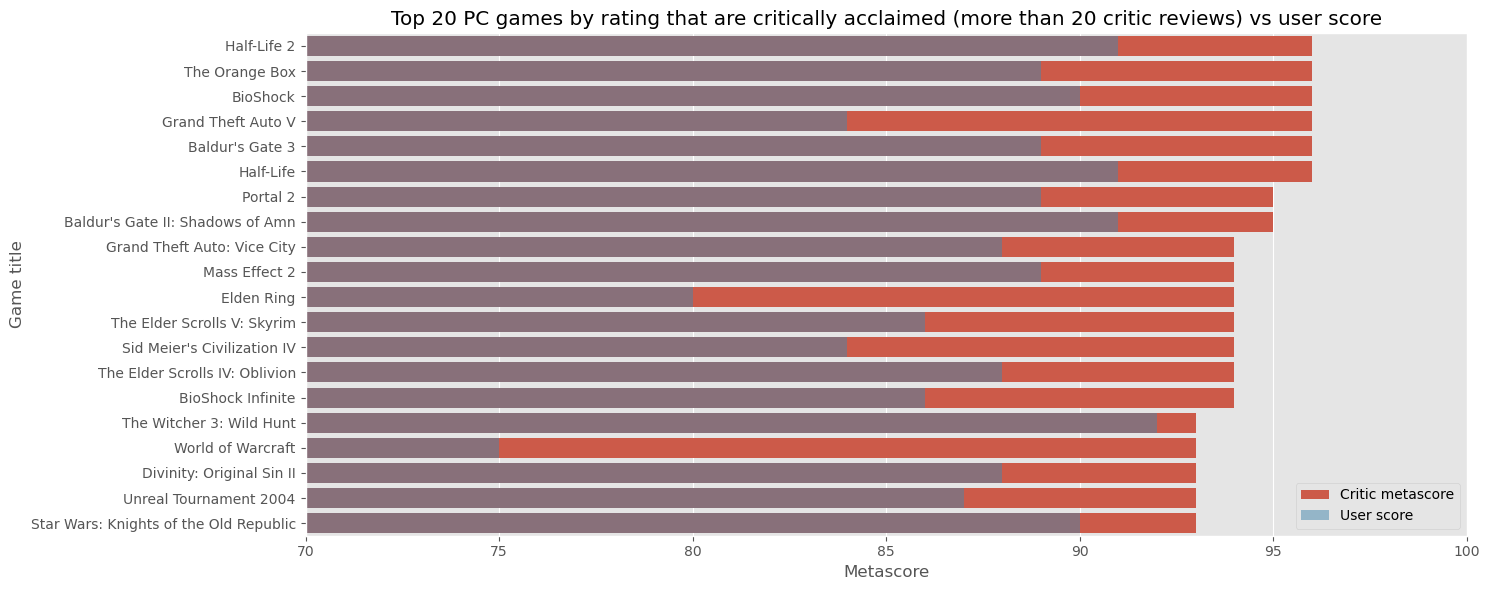

In [100]:

def plot_most_critically_acclaimed_pc_games(at_least_n_reviews) -> plt.Figure:
    critically_acclaimed_pc_games = pc_games[pc_games['platform_metascore_count'] > at_least_n_reviews]
    critically_acclaimed_pc_games = critically_acclaimed_pc_games.sort_values(by='platform_metascore', ascending=False)

    fig, ax = plt.subplots(figsize=(15, 6))

    sns.barplot(
        data=critically_acclaimed_pc_games.head(20),
        x='platform_metascore',
        y='name',
        label='Critic metascore',
        ax=ax
    )
    
    sns.barplot(
        data=critically_acclaimed_pc_games.head(20),
        x='user_score',
        y='name',
        label='User score',
        alpha=0.5,
        ax=ax,
    )

    ax.set_xlim([70, 100])
    ax.set_title(f'Top 20 PC games by rating that are critically acclaimed (more than {at_least_n_reviews} critic reviews) vs user score')
    ax.set_xlabel('Metascore')
    ax.set_ylabel('Game title')
    ax.legend(loc='lower right')

    plt.tight_layout()
    return fig
fig = plot_most_critically_acclaimed_pc_games(20)

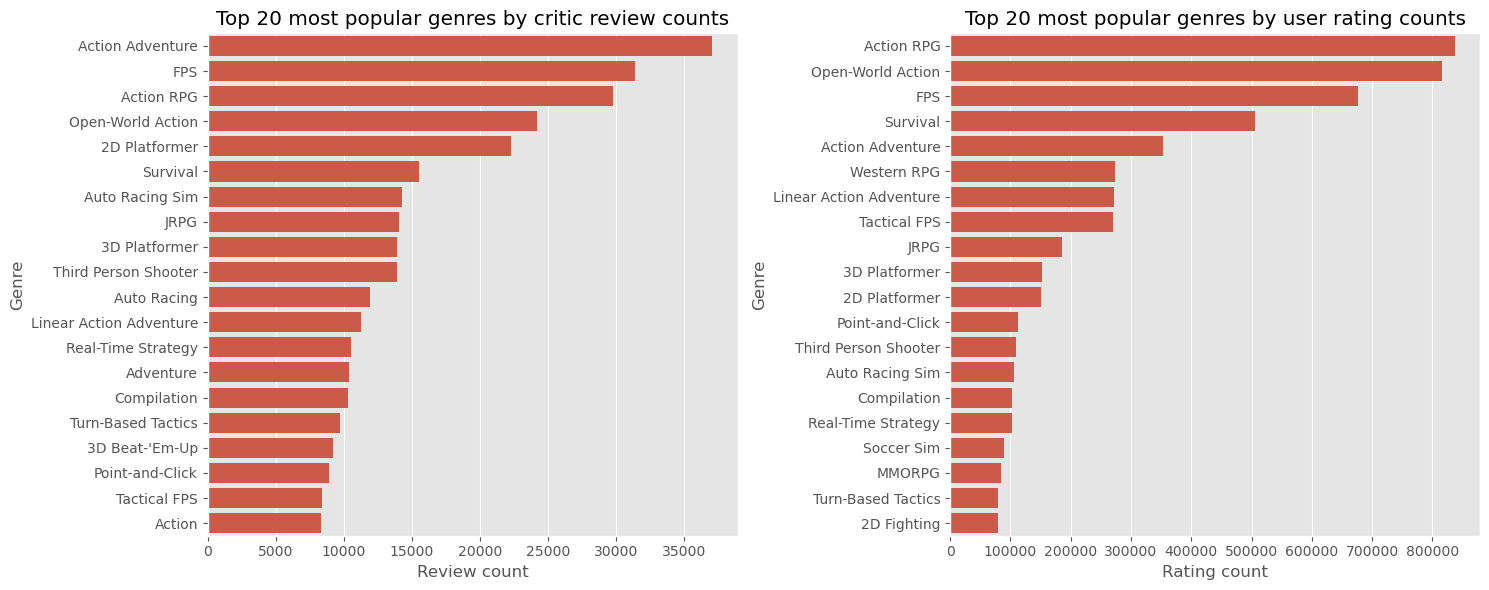

In [106]:
# Do certain genres tend to score well?
def plot_genre_popularities() -> plt.Figure:
    critics_genre_popularity = metacritic.groupby('genres')['platform_metascore_count'].agg('sum')
    critics_genre_popularity = pd.DataFrame({
        'genre': critics_genre_popularity.index,
        'critic_review_count': critics_genre_popularity.values
    })
    critics_genre_popularity = critics_genre_popularity.sort_values(by='critic_review_count', ascending=False)

    users_genre_popularity = metacritic.groupby('genres')['user_ratings_count'].agg('sum')
    users_genre_popularity = pd.DataFrame({
        'genre': users_genre_popularity.index,
        'user_rating_count': users_genre_popularity.values
    })

    users_genre_popularity = users_genre_popularity.sort_values(by='user_rating_count', ascending=False)


    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    sns.barplot(
        x=critics_genre_popularity.head(20)['critic_review_count'],
        y=critics_genre_popularity.head(20)['genre'],
        orient='h',
        ax=axes[0],
    )
    axes[0].set_title('Top 20 most popular genres by critic review counts')
    axes[0].set_xlabel('Review count')
    axes[0].set_ylabel('Genre')

    sns.barplot(
        x=users_genre_popularity.head(20)['user_rating_count'],
        y=users_genre_popularity.head(20)['genre'],
        orient='h',
        ax=axes[1],
    )
    axes[1].set_title('Top 20 most popular genres by user rating counts')
    axes[1].set_xlabel('Rating count')
    axes[1].set_ylabel('Genre')

    plt.tight_layout()
    return fig
fig = plot_genre_popularities()

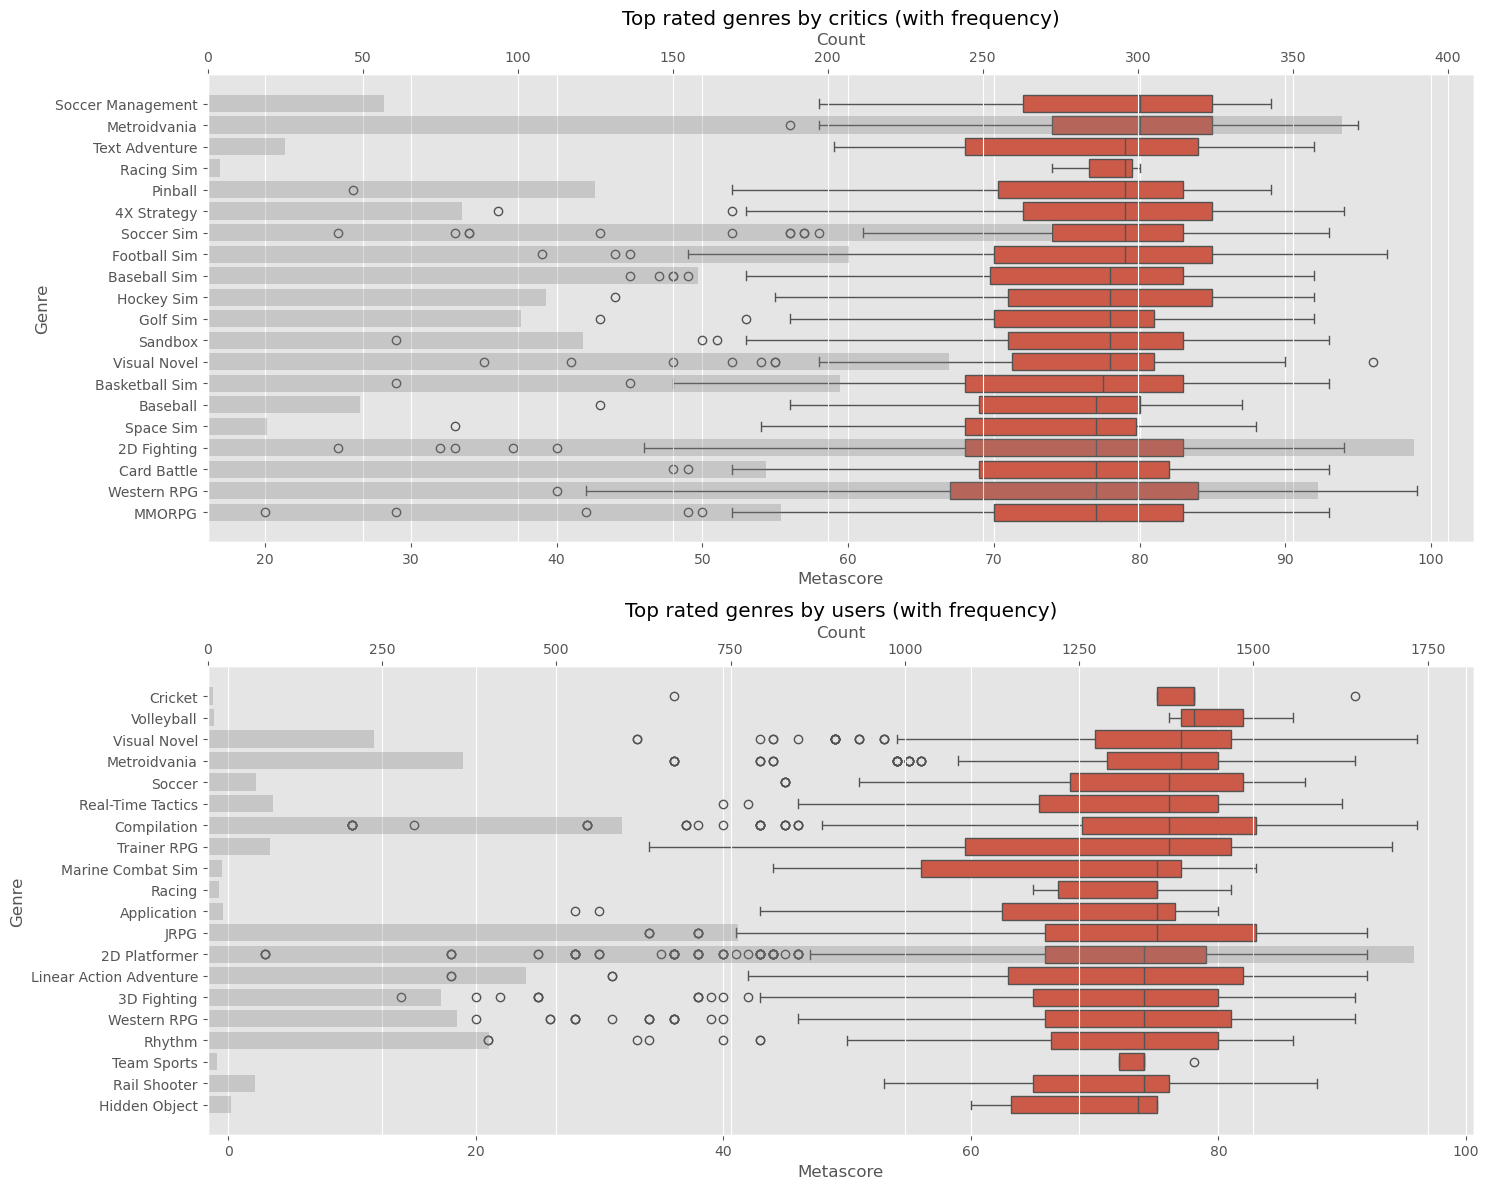

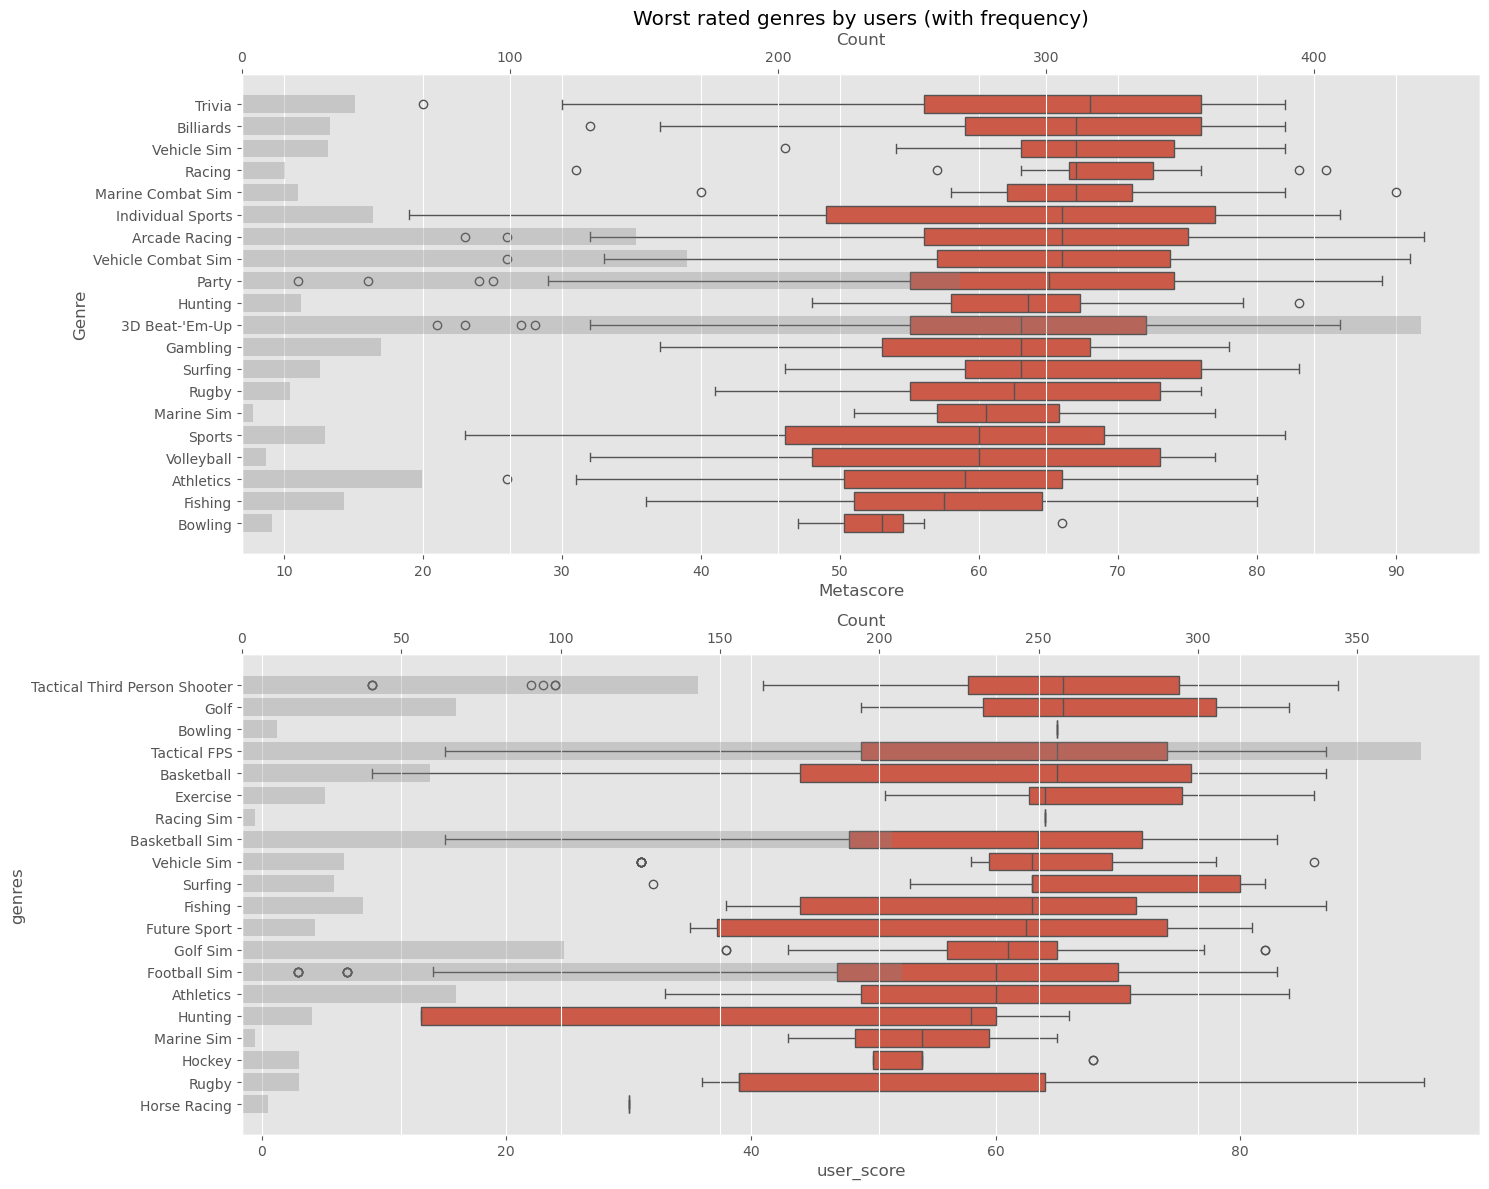

In [107]:
def plot_top_and_bottom_rated_genres_and_frequencies() -> list[plt.Figure, plt.Figure]:
    # Top Rated --------------------------- 
    genre_frequencies = metacritic['genres'].value_counts()
    genre_frequencies = pd.DataFrame({
        'genres': genre_frequencies.index,
        'count': genre_frequencies.values
    })

    critics_genre_average_score = metacritic.groupby('genres')['platform_metascore'].agg('median')
    critics_genre_average_score = pd.DataFrame({
        'genres': critics_genre_average_score.index,
        'average_critic_review_score': critics_genre_average_score.values
    })
    critics_genre_average_score = critics_genre_average_score.sort_values(by='average_critic_review_score', ascending=False)
    top_20_genres_by_critic_average_score = critics_genre_average_score.head(20)['genres']
    filtered_metacritic_by_top_20_genres_by_critic_average_score = metacritic[metacritic['genres'].isin(top_20_genres_by_critic_average_score)]

    top_rated_fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    axes: list[plt.Axes] = axes.ravel()
    sns.boxplot(
        data=filtered_metacritic_by_top_20_genres_by_critic_average_score,
        x='platform_metascore',
        y='genres',
        orient='h',
        order=top_20_genres_by_critic_average_score,
        ax=axes[0]
    )
    axes[0].set_title("Top rated genres by critics (with frequency)")
    axes[0].set_xlabel("Metascore")
    axes[0].set_ylabel("Genre")

    # Pandas sort_values accepts a parameter "key", allowing us to sort columns with a function.
    # In this case, I want to sort the genre_frequencies by the order of the top 20 genres selected earlier, to match the values to correct genre when plotting the count bars.
    # This was highly informative: https://stackoverflow.com/questions/23482668/sorting-by-a-custom-list-in-pandas/72256842#72256842
    def genres_sorter(column):
        sorted_list = top_20_genres_by_critic_average_score.values
        correspondence = {genre: order for order, genre in enumerate(sorted_list)}
        return column.map(correspondence)

    genre_frequencies = genre_frequencies.sort_values(
        by="genres",
        key=genres_sorter
    )

    frequency_bars_ax: plt.Axes = axes[0].twiny()
    frequency_bars_ax.barh(
        top_20_genres_by_critic_average_score,
        genre_frequencies[genre_frequencies['genres'].isin(top_20_genres_by_critic_average_score)]['count'],
        color="gray",
        alpha=0.3,
    )
    frequency_bars_ax.set_xlabel('Count')

    # ---------------------------

    users_genre_average_score = metacritic.groupby('genres')['user_score'].agg('median')
    users_genre_average_score = pd.DataFrame({
        'genres': users_genre_average_score.index,
        'average_user_rating_score': users_genre_average_score.values
    })

    users_genre_average_score = users_genre_average_score.sort_values(by='average_user_rating_score', ascending=False)
    top_20_genres_by_user_average_score = users_genre_average_score.head(20)['genres']
    filtered_metacritic_by_top_20_genres_by_user_average_score = metacritic[metacritic['genres'].isin(top_20_genres_by_user_average_score)]

    sns.boxplot(
        data=filtered_metacritic_by_top_20_genres_by_user_average_score,
        x='user_score',
        y='genres',
        orient='h',
        order=top_20_genres_by_user_average_score,
        ax=axes[1]
    )
    axes[1].set_title("Top rated genres by users (with frequency)")
    axes[1].set_xlabel("Metascore")
    axes[1].set_ylabel("Genre")

    def genres_sorter(column):
        sorted_list = top_20_genres_by_user_average_score.values
        correspondence = {genre: order for order, genre in enumerate(sorted_list)}
        return column.map(correspondence)

    genre_frequencies = genre_frequencies.sort_values(
        by="genres",
        key=genres_sorter
    )

    frequency_bars_ax: plt.Axes = axes[1].twiny()
    frequency_bars_ax.barh(
        top_20_genres_by_user_average_score,
        genre_frequencies[genre_frequencies['genres'].isin(top_20_genres_by_user_average_score)]['count'],
        color="gray",
        alpha=0.3,
    )
    frequency_bars_ax.set_xlabel('Count')
    plt.tight_layout()

    # Bottom Rated --------------------------- 

    bottom_20_genres_by_critic_average_score = critics_genre_average_score.tail(20)['genres']
    filtered_metacritic_by_bottom_20_genres_by_critic_average_score = metacritic[metacritic['genres'].isin(bottom_20_genres_by_critic_average_score)]

    bottom_rated_fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    axes: list[plt.Axes] = axes.ravel()
    sns.boxplot(
        data=filtered_metacritic_by_bottom_20_genres_by_critic_average_score,
        x='platform_metascore',
        y='genres',
        orient='h',
        order=bottom_20_genres_by_critic_average_score,
        ax=axes[0]
    )
    axes[0].set_title("Worst rated genres by critics (with frequency)")
    axes[0].set_xlabel("Metascore")
    axes[0].set_ylabel("Genre")

    # Pandas sort_values accepts a parameter "key", allowing us to sort columns with a function.
    # In this case, I want to sort the genre_frequencies by the order of the top 20 genres selected earlier, to match the values to correct genre when plotting the count bars.
    # This was highly informative: https://stackoverflow.com/questions/23482668/sorting-by-a-custom-list-in-pandas/72256842#72256842
    def genres_sorter(column):
        sorted_list = bottom_20_genres_by_critic_average_score.values
        correspondence = {genre: order for order, genre in enumerate(sorted_list)}
        return column.map(correspondence)

    genre_frequencies = genre_frequencies.sort_values(
        by="genres",
        key=genres_sorter
    )

    frequency_bars_ax: plt.Axes = axes[0].twiny()
    frequency_bars_ax.barh(
        bottom_20_genres_by_critic_average_score,
        genre_frequencies[genre_frequencies['genres'].isin(bottom_20_genres_by_critic_average_score)]['count'],
        color="gray",
        alpha=0.3,
    )
    frequency_bars_ax.set_xlabel('Count')

    # ---------------------------

    bottom_20_genres_by_user_average_score = users_genre_average_score.tail(20)['genres']
    filtered_metacritic_by_bottom_20_genres_by_user_average_score = metacritic[metacritic['genres'].isin(bottom_20_genres_by_user_average_score)]

    sns.boxplot(
        data=filtered_metacritic_by_bottom_20_genres_by_user_average_score,
        x='user_score',
        y='genres',
        orient='h',
        order=bottom_20_genres_by_user_average_score,
        ax=axes[1]
    )
    axes[0].set_title("Worst rated genres by users (with frequency)")
    axes[0].set_xlabel("Metascore")
    axes[0].set_ylabel("Genre")

    def genres_sorter(column):
        sorted_list = bottom_20_genres_by_user_average_score.values
        correspondence = {genre: order for order, genre in enumerate(sorted_list)}
        return column.map(correspondence)

    genre_frequencies = genre_frequencies.sort_values(
        by="genres",
        key=genres_sorter
    )

    frequency_bars_ax: plt.Axes = axes[1].twiny()
    frequency_bars_ax.barh(
        bottom_20_genres_by_user_average_score,
        genre_frequencies[genre_frequencies['genres'].isin(bottom_20_genres_by_user_average_score)]['count'],
        color="gray",
        alpha=0.3,
    )
    frequency_bars_ax.set_xlabel('Count')
    plt.tight_layout()

    return top_rated_fig, bottom_rated_fig
fig_1, fig_2 = plot_top_and_bottom_rated_genres_and_frequencies()



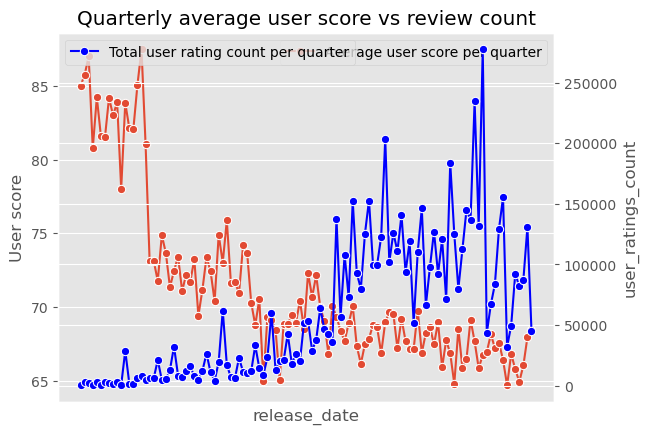

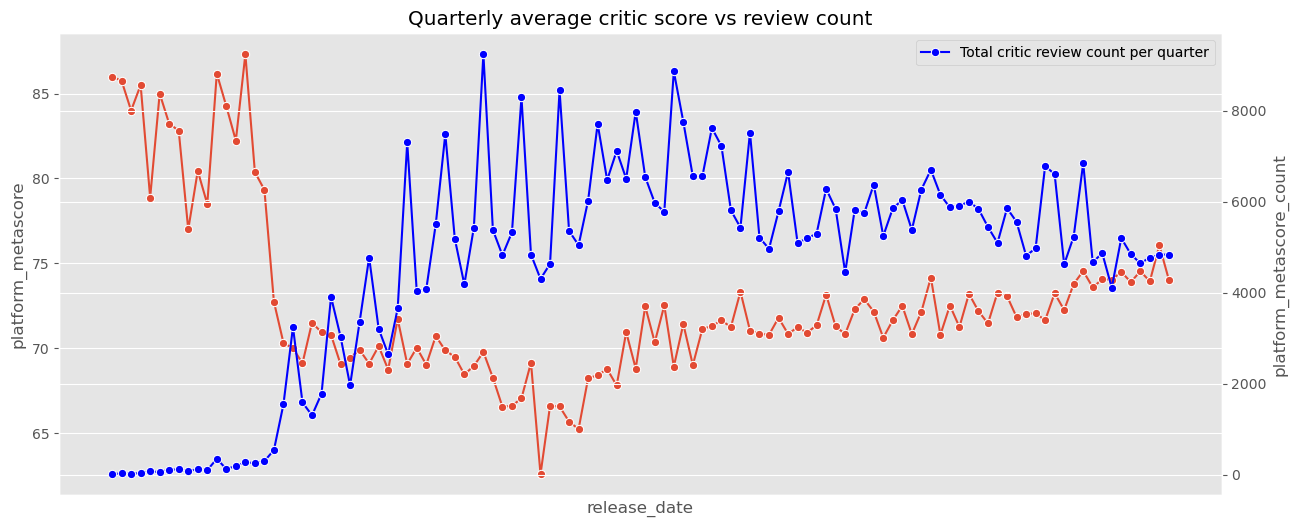

In [121]:
# Have users and critics been rating things worse over time?
# What does the avg user score look like over the years?
def plot_quarterly_user_score_distribution() -> plt.Figure:
    fig = plt.figure()
    user_score_group_by_quarter=metacritic.groupby(metacritic['release_date'].dt.to_period('Q')).agg({'name':'count','user_score':'mean'}).reset_index()
    user_score_group_by_quarter=user_score_group_by_quarter.iloc[:-1,:]
    user_score_group_by_quarter['release_date']=user_score_group_by_quarter['release_date'].astype(str)

    sns.lineplot(
        data = user_score_group_by_quarter,
        x='release_date',
        y=user_score_group_by_quarter['user_score'],
        label='Average user score per quarter',
        marker='o',
    )
    plt.title("Quarterly average user score vs review count")
    plt.xticks([])
    plt.ylabel("User score")

    user_ratings_count_group_by_quarter=metacritic.groupby(metacritic['release_date'].dt.to_period('Q')).agg({'name':'count', 'user_ratings_count': 'sum'}).reset_index()
    user_ratings_count_group_by_quarter=user_ratings_count_group_by_quarter.iloc[:-1,:]
    user_ratings_count_group_by_quarter['release_date']=user_ratings_count_group_by_quarter['release_date'].astype(str)

    ax_twin = plt.gca().twinx()
    sns.lineplot(
        data = user_ratings_count_group_by_quarter,
        x ='release_date',
        y=user_ratings_count_group_by_quarter['user_ratings_count'],
        label='Total user rating count per quarter',
        color='b',
        marker='o',
        ax=ax_twin
    )
    ax_twin.legend()
    plt.legend()
    return fig
fig = plot_quarterly_user_score_distribution()

def plot_quarterly_critic_score_distribution() -> plt.Figure:
    plt.figure(figsize=(15, 6))
    critic_score_group_by_quarter=metacritic.groupby(metacritic['release_date'].dt.to_period('Q')).agg({'name':'count','platform_metascore':'mean'}).reset_index()
    critic_score_group_by_quarter=critic_score_group_by_quarter.iloc[:-1,:]
    critic_score_group_by_quarter['release_date']=critic_score_group_by_quarter['release_date'].astype(str)

    sns.lineplot(
        data = critic_score_group_by_quarter,
        x='release_date',
        y=critic_score_group_by_quarter['platform_metascore'],
        label='Total critic review count per quarter',
        marker='o',
    )
    plt.title("Quarterly average critic score vs review count")
    plt.xticks([])
    plt.ylabel("platform_metascore")

    critic_review_count_group_by_quarter=metacritic.groupby(metacritic['release_date'].dt.to_period('Q')).agg({'name':'count', 'platform_metascore_count': 'sum'}).reset_index()
    critic_review_count_group_by_quarter=critic_review_count_group_by_quarter.iloc[:-1,:]
    critic_review_count_group_by_quarter['release_date']=critic_review_count_group_by_quarter['release_date'].astype(str)

    ax_twin = plt.gca().twinx()
    sns.lineplot(
        data = critic_review_count_group_by_quarter,
        x ='release_date',
        y=critic_review_count_group_by_quarter['platform_metascore_count'],
        color='b',
        label='Total critic review count per quarter',
        marker='o',
        ax=ax_twin
    )
    return fig
fig = plot_quarterly_critic_score_distribution()

# Dashboard

In [28]:
def plot_most_critically_acclaimed_pc_games(at_least_n_reviews):
    pc_games = metacritic[metacritic['platform_name'] == 'PC']
    critically_acclaimed_pc_games = pc_games[pc_games['platform_metascore_count'] > at_least_n_reviews]
    critically_acclaimed_pc_games = critically_acclaimed_pc_games.sort_values(by='platform_metascore', ascending=False)

    top_20_games = critically_acclaimed_pc_games.head(20)

    colors = pc.qualitative.Plotly

    fig = go.Figure()

    fig.add_trace(go.Bar(
        x=top_20_games['platform_metascore'],
        y=top_20_games['name'],
        orientation='h',
        name='Critic metascore',
        marker=dict(color=colors[0])
    ))

    fig.add_trace(go.Bar(
        x=top_20_games['user_score'],
        y=top_20_games['name'],
        orientation='h',
        name='User score',
        marker=dict(color=colors[1])
    ))

    fig.update_layout(
        title=f'Top 20 PC games by rating (with more than {at_least_n_reviews} critic reviews) vs user score',
        legend=dict(x=.8, y=1),
        xaxis=dict(title='Score', range=[70, 100]),
        yaxis=dict(title='Game title'),
        barmode='overlay',
        height=600,
        width=900
    )
    return fig

fig = plot_most_critically_acclaimed_pc_games(20)
fig.show()


In [30]:
def plot_top_and_bottom_rated_genres_and_frequencies(n=0):
    genre_frequencies = metacritic['genres'].value_counts()
    genre_frequencies_df = pd.DataFrame({
        'genres': genre_frequencies.index,
        'count': genre_frequencies.values
    })
    genre_frequencies_df = genre_frequencies_df[genre_frequencies_df['count'] >= n]
    critics_genre_average_score = metacritic.groupby('genres')['platform_metascore'].agg('median')
    critics_genre_average_score_df = pd.DataFrame({
        'genres': critics_genre_average_score.index,
        'average_critic_review_score': critics_genre_average_score.values
    })
    critics_genre_average_score_df = critics_genre_average_score_df.sort_values(by='average_critic_review_score', ascending=False)
    top_20_genres_by_critic_average_score = critics_genre_average_score_df[critics_genre_average_score_df['genres'].isin(genre_frequencies_df['genres'])].head(20)['genres']
    filtered_metacritic_by_top_20_genres = metacritic[metacritic['genres'].isin(top_20_genres_by_critic_average_score)]

    colors = pc.qualitative.Plotly

    # Boxes
    fig = go.Figure()
    for genre in top_20_genres_by_critic_average_score:
        genre_data = filtered_metacritic_by_top_20_genres[filtered_metacritic_by_top_20_genres['genres'] == genre]
        fig.add_trace(go.Box(
            x=genre_data['platform_metascore'],
            name=genre,
            orientation='h',
            boxmean=True,
            marker=dict(color=colors[1]),
            xaxis='x'
        ))

    genre_frequencies_df = genre_frequencies_df.set_index('genres').reindex(top_20_genres_by_critic_average_score)

    # Frequency bars
    fig.add_trace(go.Bar(
        y=top_20_genres_by_critic_average_score,
        x=genre_frequencies_df['count'],
        orientation='h',
        marker=dict(color='rgba(128, 128, 128, 0.3)'),
        xaxis='x2'
    ))

    fig.update_layout(
        title="Top rated genres by critics (with frequency)",
        xaxis=dict(
            title="Metascore",
            side='bottom'
        ),
        xaxis2=dict(
            title="Count",
            side='top',
            overlaying='x'
        ),
        yaxis=dict(
            title="Genre"
        ),
        barmode='overlay',
        height=600,
        width=900,
        showlegend=False
    )

    return fig

fig = plot_top_and_bottom_rated_genres_and_frequencies(n=500)
fig.show()
